<a href="https://colab.research.google.com/github/pranavm1502/COS-485/blob/master/Backprop2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backpropagation learning for multilayer perceptron

In [0]:
# installs
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 79.1MB 50.1MB/s 
    100% |████████████████████████████████| 2.0MB 8.5MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
fastai 1.0.45 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


In [0]:
# imports 
import torch
import torch.nn as nn
import torchvision
import numpy as np 
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from IPython import display
import time

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [0]:
# get data
mnist = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.train_data
trainlabels = mnist.train_labels

def get_features(i):
    """return feature vector for i'th training example"""
    im = trainimages[i].float() / 255.0 # rescale
    ft = im.view(-1) # flatten
    return ft 

def get_onehot(i):
    """return onehot label vector for i'th training example"""
    onehot = torch.zeros(10).float()
    onehot[trainlabels[i]] = 1.0
    return onehot

Processing...
Done!


In [0]:
# fn to visualize training 
def visualize_training(errsq, errcl, x0, x1, x2, W1, t):
    # convert things to numpy, numpy is easier to use with matplotlib 
    errsq, errcl, x0, x1, x2, W1 = [x.numpy() for x in [errsq, errcl, x0, x1, x2, W1]]
    
    # visualization
    avgerrsq = np.divide( np.cumsum(errsq[0:t]), np.arange(1,t+1) )
    avgerrcl = np.divide( np.cumsum(errcl[0:t]), np.arange(1,t+1) )

    fig = plt.figure(figsize=fig_size)
    gs = gridspec.GridSpec(6,5, wspace=0.3, hspace=0.1)

    ax = fig.add_subplot(gs[0,0])
    ax.axis('off')
    ax.set_title("x0 at t={}".format(t))
    ax.imshow(x0.reshape(28,28), origin='upper', interpolation='nearest') 

    ax = fig.add_subplot(gs[0,1])
    ax.bar(range(len(x1)), x1)
    ax.set_ylabel("layer1")
    ax.set_ylim((-1, 2))
    ax.grid()

    ax = fig.add_subplot(gs[0,2])
    ax.bar(range(len(x2)), x2)
    ax.set_ylabel("output")
    ax.set_ylim((-1,2))
    ax.set_xticks(range(0,10))
    ax.grid()

    ax = fig.add_subplot(gs[0,3:5])
    ax.plot(avgerrsq, label="squared")
    ax.plot(avgerrcl, label="class")
    ax.set_ylabel("error")
    ax.set_ylim([0,1])
    ax.grid()
    ax.legend()

    n1 = W1.shape[0]
    for i in range(n1):
        ax = fig.add_subplot(gs[1 + i // 5, i % 5])
        ax.axis('off')
        ax.imshow(W1.T.reshape(28,28,n1)[:,:,i], origin='upper', interpolation='nearest') 

    display.display(plt.gcf())
    time.sleep(0.01)
    display.clear_output(wait=True)
    fig.clf()
    plt.close(fig)  

In [0]:
# functions to build and train networks 
def train_twolayer_network(f, df, eta, epsinit, tmax, fig_size):
    """Build and train two layer neural network
    
    Args:
        f: function, activation function, maps torch tensor to another torch tensor
        df: function, derivative of activation function, maps torch tensor to another torch tensor
        eta: float, learning rate
        epsinit: float, magnitude of initial weights
        tmax: int, max number of training updates
        fig_size: (x, y) size of figure to plot, may need to change to properly fit your screen
    """
    ### setup network architecture ###
    m = 60000                # number of examples in training set

    n0 = 784                 # widths of layers
    n1 = 25
    n2 = 10  

    # two fully connected synaptic layers
    W1 = epsinit*torch.randn(n1, n0)
    W2 = epsinit*torch.randn(n2, n1)

    # biases
    b1 = epsinit*torch.randn(n1)
    b2 = epsinit*torch.randn(n2)

    # training parameters
    tshow = 1000             # how often to pause for visualization
    errsq = torch.zeros(tmax) # track squared error 
    errcl = torch.zeros(tmax) # track classification error 

    ### iterate through training data ###
    for t in range(tmax):
        # get and format example
        i = int(np.floor(m*np.random.rand()))
        x0 = get_features(i)
        y = get_onehot(i)

        # forward pass
        x1 = f(torch.matmul(W1,x0) + b1)
        x2 = f(torch.matmul(W2,x1) + b2)

        # compute error 
        errsq[t] = 0.5*torch.sum((y-x2)**2)
        errcl[t] = float(np.argmax(x2.numpy()) != trainlabels[i])

        # backward pass
        delta2 = -1*(y-x2) * df(x2)
        delta1 = torch.matmul(torch.t(W2), delta2) * df(x1)

        # update weights
        W2 -= eta * torch.ger(delta2, x1) # torch.ger(x,y) means outer product of x,y
        W1 -= eta * torch.ger(delta1, x0)
        b2 -= eta * delta2
        b1 -= eta * delta1

        # visualize training 
        if t % tshow == 0: 
            visualize_training(errsq, errcl, x0, x1, x2, W1, t)
            
def train_threelayer_network(f, df, eta, epsinit, tmax, fig_size): 
    ### Your code here ###
    raise NotImplementedError

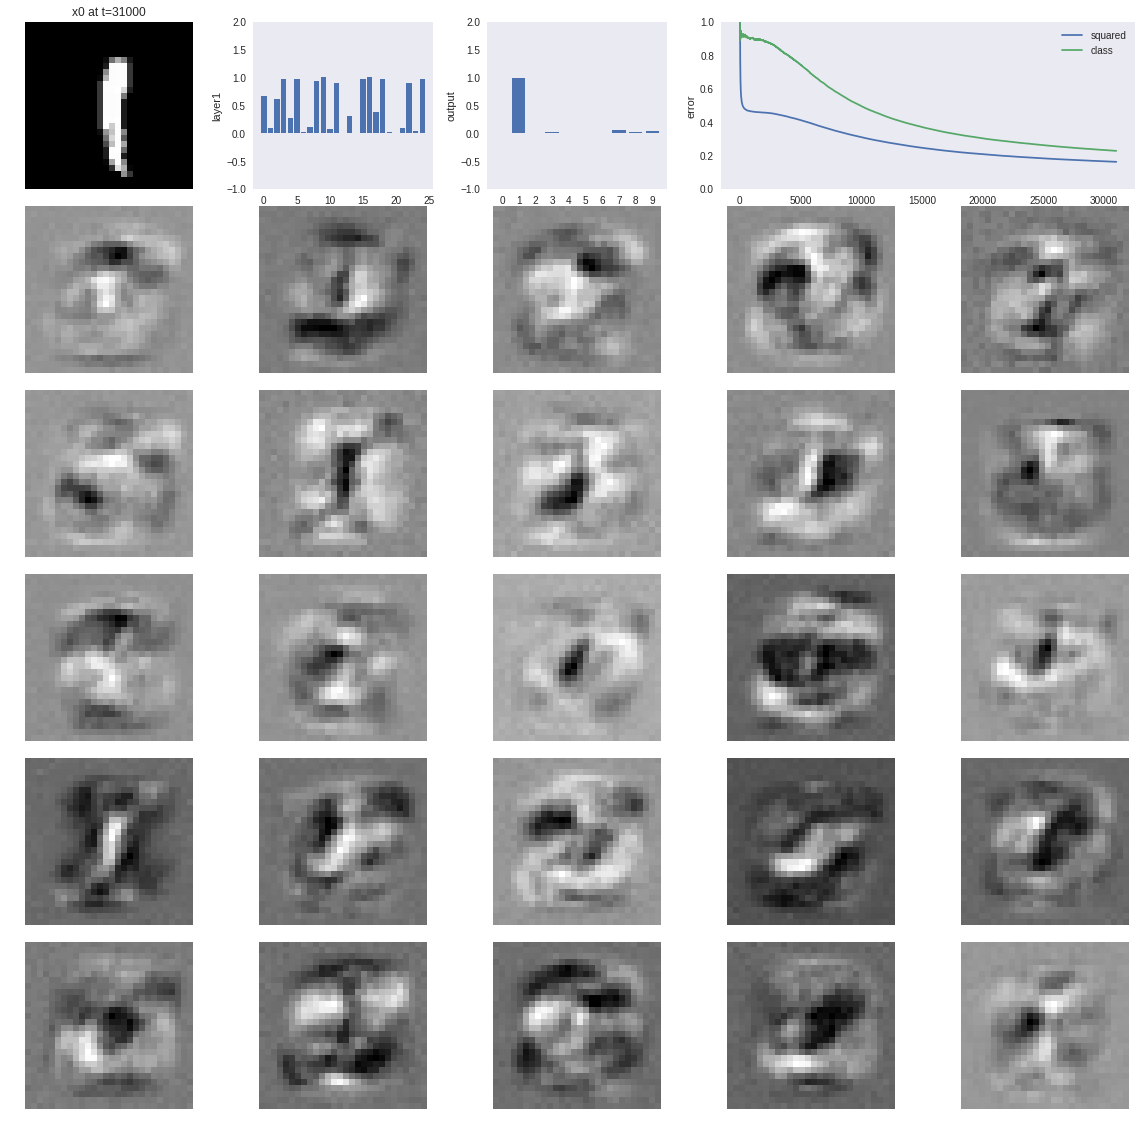

In [0]:
### Train 2-layer perceptron with sigmoid activation ###
def f(x):
    return 1 / (1+torch.exp(-x))
def df(y):
    return y * (1-y)
eta = 0.1 # learning rate 
epsinit = 0.01 #initial scale of weights
tmax = int(6*10**5) # number of training iterations 
fig_size = (20,20) # size of figure, may need to modify to make plots fit screen

train_twolayer_network(f, df, eta, epsinit, tmax, fig_size)

In [0]:
### Train 2-layer perceptron with hyperbolic tangent activation ###
def f(x):
    ### Your code here ###
    raise NotImplementedError
def df(y):
    ### Your code here ###
    raise NotImplementedError
eta = 0.1
epsinit = 0.01
tmax = int(6*10**5)
fig_size = (20,20)

train_twolayer_network(f, df, eta, epsinit, tmax, fig_size)

In [0]:
### Train 2-layer perceptron with ReLU activation ###
def f(x):
    ### Your code here ###
    raise NotImplementedError
def df(y):
    ### Your code here ###
    raise NotImplementedError
eta = 0.1
epsinit = 0.01
tmax = int(6*10**5)
fig_size = (20,20)

train_twolayer_network(f, df, eta, epsinit, tmax, fig_size)

In [0]:
### Train 3-layer perceptron with ReLU activation functions ###
def f(x):
    ### Your code here ###
    raise NotImplementedError
def df(y):
    ### Your code here ###
    raise NotImplementedError

eta = 0.1
epsinit = 0.01
tmax = int(6*10**5)
fig_size = (20,20)

train_threelayer_network(f, df, eta, epsinit, tmax, fig_size)

**Autograd**

In [0]:
# autograd version of two layer network
def train_twolayer_network_autograd(f, eta, epsinit, tmax, fig_size):
    """Build and train two layer neural network
    
    Args:
        f: function, activation function, maps torch tensor to another torch tensor
        eta: float, learning rate
        epsinit: float, magnitude of initial weights
        tmax: int, max number of training updates
        fig_size: (x, y) size of figure to plot, may need to change to properly fit your screen
    """
    ### setup network architecture ###
    m = 60000                # number of examples in training set

    n0 = 784                 # widths of layers
    n1 = 25
    n2 = 10  

    # two fully connected synaptic layers
    W1 = nn.Parameter(epsinit*torch.randn(n1, n0))
    W2 = nn.Parameter(epsinit*torch.randn(n2, n1))

    # biases
    b1 = nn.Parameter(epsinit*torch.randn(n1))
    b2 = nn.Parameter(epsinit*torch.randn(n2))
    
    # create optimizer
    optim = torch.optim.SGD([W1,W2,b1,b2], eta)

    # training parameters
    tshow = 1000             # how often to pause for visualization
    errsq = torch.zeros(tmax) # track squared error 
    errcl = torch.zeros(tmax) # track classification error 

    ### iterate through training data ###
    for t in range(tmax):
        # get and format example
        i = int(np.floor(m*np.random.rand()))
        x0 = get_features(i)
        y = get_onehot(i)
        
        # zero gradients, without this, pytorch will add new grads to previous ones
        optim.zero_grad()

        # forward pass
        x1 = f(torch.matmul(W1,x0) + b1)
        x2 = f(torch.matmul(W2,x1) + b2)

        # compute error 
        e = 0.5*torch.sum((y-x2)**2)
        errsq[t] = e
        errcl[t] = float(np.argmax(x2.detach().numpy()) != trainlabels[i])

        # backward pass
        e.backward()

        # update weights
        optim.step()

        # visualize training 
        if t % tshow == 0: 
            visualize_training(errsq.detach(), errcl.detach(), x0.detach(), x1.detach(), x2.detach(), W1.detach(), t)

In [0]:
### Train 2-layer perceptron with sigmoid activation ###
def f(x):
    return 1 / (1+torch.exp(-x))

eta = 0.1 # learning rate 
epsinit = 0.01 #initial scale of weights
tmax = int(6*10**5) # number of training iterations 
fig_size = (20,20) # size of figure, may need to modify to make plots fit screen

train_twolayer_network_autograd(f, eta, epsinit, tmax, fig_size)